In [60]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
import os
print(os.listdir('/content/drive/MyDrive/dataset'))

['Venous Ulcer', 'Diabetic Ulcer', 'Pressure Ulcer', 'Not a wound', 'Surgical Wound']


In [63]:
X=[]
Z=[]
IMG_SIZE=150
Venous='/content/drive/MyDrive/dataset/Venous Ulcer'
Surgical='/content/drive/MyDrive/dataset/Surgical Wound'
Diabetic='/content/drive/MyDrive/dataset/Diabetic Ulcer'
Pressure='/content/drive/MyDrive/dataset/Pressure Ulcer'
Nowound = '/content/drive/MyDrive/dataset/Not a wound'
weights_path='/content/drive/MyDrive/weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [64]:
def assign_label(img,wound_type):
    return wound_type

In [65]:
def make_train_data(wound_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,wound_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [66]:
make_train_data('Venous',Venous)
print(len(X))

100%|██████████| 500/500 [00:02<00:00, 238.23it/s]

500


In [67]:
make_train_data('Surgical',Surgical)
print(len(X))

100%|██████████| 500/500 [00:11<00:00, 43.77it/s]

1000


In [68]:
make_train_data('Diabetic',Diabetic)
print(len(X))

100%|██████████| 500/500 [00:01<00:00, 251.74it/s]

1500


In [69]:
make_train_data('Pressure',Pressure)
print(len(X))

100%|██████████| 500/500 [00:02<00:00, 242.34it/s]

2000


In [70]:
make_train_data('Nowound',Nowound)
print(len(X))

100%|██████████| 500/500 [00:04<00:00, 105.77it/s]

2500


[link text](https://)2.2 ) Visualizing some Random Images

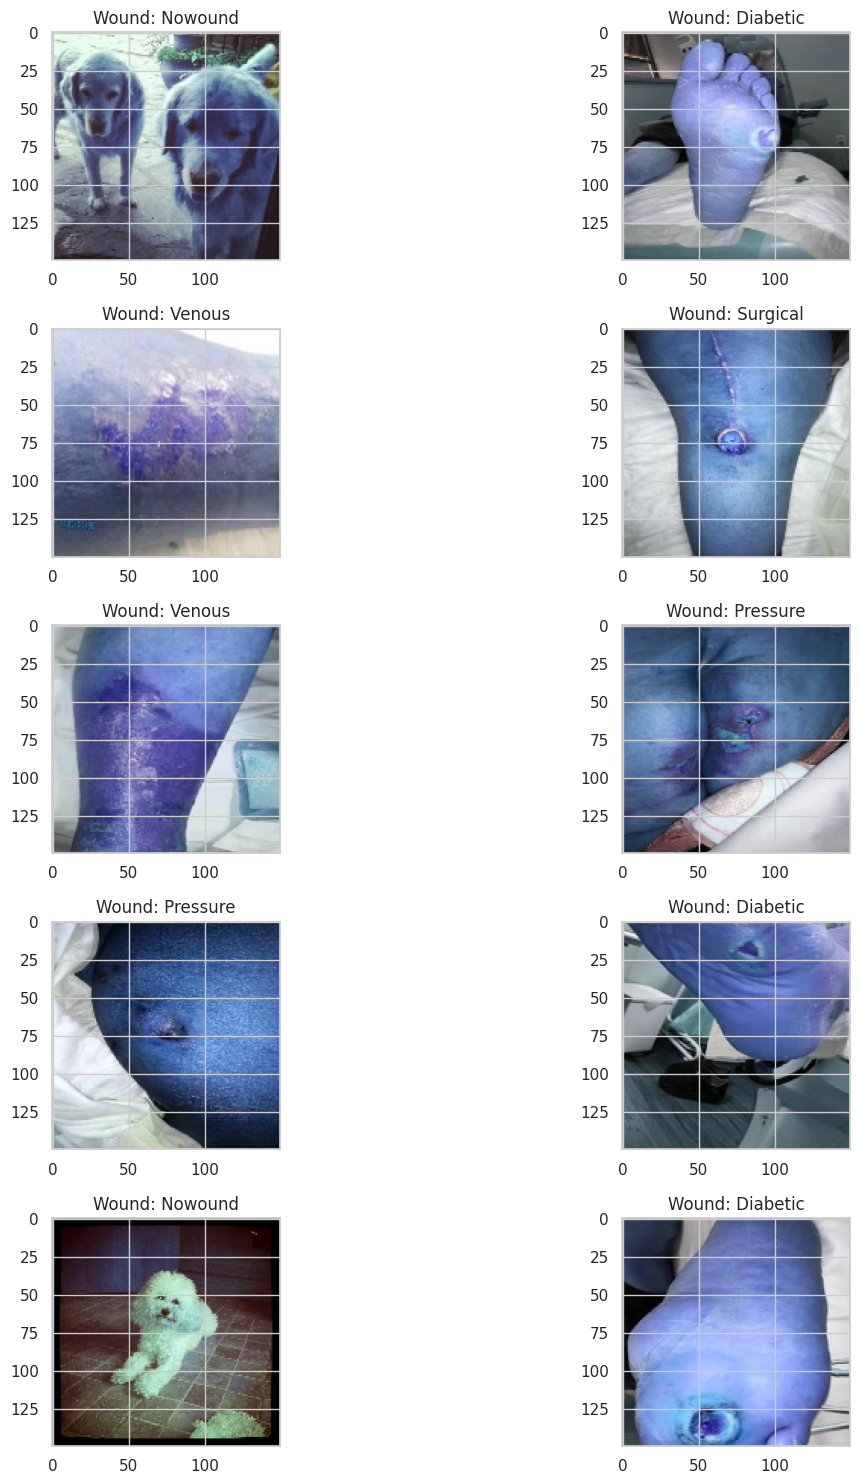

In [71]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Wound: '+Z[l])
        
plt.tight_layout()

2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding


In [72]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255 

2.4 ) Splitting into Training and Validation Sets¶


In [73]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


In [74]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

Modelling

3.1 ) Specifying the Base Model¶

Transfer learning refers to using a pretrained model on some other task for your own task. Hence we need to specify the particular model which we are deploying in our task and thus needs to specify the base model.

In our case we are using the VGG16 model from the Keras.Applications library as the base model.




In [75]:
base_model=VGG16(include_top=False, weights=None,input_shape=(150,150,3), pooling='avg')


In [76]:
base_model.load_weights(weights_path)


BREAKING IT DOWN--
1) Firstly we import the VGG16 module from the Keras library.

2) Next we need to specify if we want to use the fully connected layers of the VGG16 module or own layers. Since our task is different and we have only 5 target classes we need to have our own layers and I have specified the 'include_top' arguement as 'False'.

3) Next we need to specify the weights to be used by the model. Since I want it to use the weights it was trained on in ImageNet competition, I have loaded the weights from the corressponding file. You can directly specify the weights arguement as 'imagenet' in VGG16( ) but it didn't work in my case so I have to explicitily load the weghts from a file.

4) Lastly we just need to specify the shape of the imput that our model need to expect and also specify the 'pooling' type.

In [77]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Note that this is NOT the summary of our model and this is the summary or the ARCHITECTURE of the VGG16 model that we are deploying as the base model.



3.2 ) Adding our Own Fully Connected Layers

Now we need to add at the top of the base model some fully connected layers. Alsowe can use the BatchNormalization and the Dropout layers as usual in case we want to.

For this I have used a Keras sequential model and build our entire model on top of it; comprising of the VGG model as the base model + our own fully connected layers.

In [78]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

3.3 ) Data Augmentation to prevent Overfitting¶


In [79]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

3.4 ) Using a Learning Rate Annealer & the Summary¶


In [80]:
epochs=25
batch_size=8
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

In [81]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 14,847,301
Trainable params: 14,847,301
Non-trainable params: 0
_________________________________________________________________


This is now the complete summary of our model that we shall use to classify the images.



3.5 ) Compiling & Training the Model

3.5.1 ) USING BASE MODEL AS A FEATURE EXTRACTOR.

While using transfer learning in ConvNet; we have basically have 3 main approaches-->

1) To use the pretrained model as a feature extractor and just train your classifier on top of it. In this method we do not tune any weights of the model.

2) Fine Tuning- In this approach we tune the weights of the pretrained model. This can be done by unfreezing the layers that we want to train.In that case these layers will be initialised with their trained weights on imagenet.

3) Lasty we can use a pretrained model.

Note that in this section I have used the first approach ie I have just use the conv layers and added my own fully connected layers on top of VGG model. Thus I have trained a classifier on top of the CNN codes

3.5.2 ) FINE TUNING BY UNFREEZING THE LAST BLOCK OF VGG16¶
In this section I have done fine tuning. To see the effect of the fine tuning I have first unfreezed the last block of the VGG16 model and have set it to trainable.

In [82]:
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])
  
for layer in base_model.layers[15:]:
    layer.trainable=False
for layer in base_model.layers[0:15]:
    layer.trainable=True

0 <keras.engine.input_layer.InputLayer object at 0x7f44e8185e20>
1 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f44e81aefa0>
2 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f44e819afa0>
3 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f44e84efd30>
4 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f44e82d4b80>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f44edb44dc0>
6 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f44e84fbf10>
7 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f44e8271340>
8 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f44e84fbc40>
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f44e84fb880>
10 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f44e84f07f0>
11 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f44e85025e0>
12 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f44e85506a0>
13 <keras.layers.convolutional.conv2d.Conv2D object at 0x7f44e84fbf70>


In [83]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 40, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)


Epoch 1/40
234/234 [==============================] - 26s 94ms/step - loss: 1.3442 - accuracy: 0.4119 - val_loss: 1.2585 - val_accuracy: 0.4864
Epoch 2/40
234/234 [==============================] - 20s 85ms/step - loss: 1.0517 - accuracy: 0.5512 - val_loss: 1.0110 - val_accuracy: 0.5856
Epoch 3/40
234/234 [==============================] - 21s 88ms/step - loss: 0.8635 - accuracy: 0.6513 - val_loss: 0.7889 - val_accuracy: 0.6800
Epoch 4/40
202/234 [========================>.....] - ETA: 2s - loss: 0.8027 - accuracy: 0.6809

The validation accuracy on fine tuning by unfreezing the last block of the VGG16 model has increased to about 81% ; almost by 3% as compared to the case when we run a classifier on the top of the CNN codes in previous section.¶

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
# Evaluating the model on the test data
results = model.evaluate(x_test, y_test)
print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

In [ ]:
# Create predictions for test images
predictions = model.predict(x_test)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

In [ ]:
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[:20]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    rounded_labels, 
    predictions, 
    target_names = ['Venous Ulcer', 'Surgical Wound', 'Diabetic Ulcer', 'Pressure Ulcer','Not a wound']))

In [ ]:
# Confusion matrix plot function and execute 
class_names = ['Venous Ulcer', 'Surgical Wound', 'Diabetic Ulcer', 'Pressure Ulcer', 'Not a wound']
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)

In [ ]:
# Plot confusion matrix for Model 3

cm = confusion_matrix(rounded_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3','4'], columns = ['0', '1', '2', '3','4'])
plot_confusion_matrix(cm)

In [ ]:
print(History)

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()